# 在Sagemaker上基于特征向量机算法实现电影推荐

## 实验步骤
* 实验介绍
* 数据准备
* 数据预处理+介绍Data Wrangler
* 模型训练
* 模型部署
* 模型推理

## 实验介绍

![架构图](images/architecture.png)

### 因子分解机算法介绍
该实验使用movielens，采用Sagemaker 托管的FM（因子分解机）算法实现推荐. 

![架构图](images/FM-intro.png)

主要考虑到多维特征（隐含特征）之间的交叉关系，其中参数的训练使用的是矩阵分解的方法。

In [34]:
import sagemaker
import sagemaker.amazon.common as smac
from sagemaker import get_execution_role
from sagemaker.predictor import json_deserializer

import boto3, csv, io, json
import numpy as np
from scipy.sparse import lil_matrix
import pandas as pd

### 数据准备

数据集说明: http://files.grouplens.org/datasets/movielens/ml-100k-README.txt


In [2]:
!wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip -o ml-100k.zip

--2020-12-08 04:11:27--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  13.0MB/s    in 0.4s    

2020-12-08 04:11:28 (13.0 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base

## 数据分析
* 我们先来分析一下u.data的数据，这里包含的是用户的观影记录数据

In [35]:
data = pd.read_csv("ml-100k/u.data",sep='\t',header = None ,names=['userid','movieid','rating','timestamp'])
data.head

<bound method NDFrame.head of        userid  movieid  rating  timestamp
0         196      242       3  881250949
1         186      302       3  891717742
2          22      377       1  878887116
3         244       51       2  880606923
4         166      346       1  886397596
...       ...      ...     ...        ...
99995     880      476       3  880175444
99996     716      204       5  879795543
99997     276     1090       1  874795795
99998      13      225       2  882399156
99999      12      203       3  879959583

[100000 rows x 4 columns]>

* 下来我们看一下产品数据,产品信息列包含影片的信息

In [5]:
import pandas as pd
items = pd.read_csv("ml-100k/u.item",sep='|',header = None , encoding ="ISO-8859-1",usecols=[0,1,2,3,4,5,6,7,8,9,10])
items.head

<bound method NDFrame.head of         0                                          1            2   3   \
0        1                           Toy Story (1995)  01-Jan-1995 NaN   
1        2                           GoldenEye (1995)  01-Jan-1995 NaN   
2        3                          Four Rooms (1995)  01-Jan-1995 NaN   
3        4                          Get Shorty (1995)  01-Jan-1995 NaN   
4        5                             Copycat (1995)  01-Jan-1995 NaN   
...    ...                                        ...          ...  ..   
1677  1678                          Mat' i syn (1997)  06-Feb-1998 NaN   
1678  1679                           B. Monkey (1998)  06-Feb-1998 NaN   
1679  1680                       Sliding Doors (1998)  01-Jan-1998 NaN   
1680  1681                        You So Crazy (1994)  01-Jan-1994 NaN   
1681  1682  Scream of Stone (Schrei aus Stein) (1991)  08-Mar-1996 NaN   

                                                     4   5   6   7   8   9   \
0 

* 下来我们看一下用户数据

In [6]:
import pandas as pd
users = pd.read_csv("ml-100k/u.user",sep='|',header = None , encoding ="ISO-8859-1",names=['userid','age','gender','occupation','zip'])
users.head

<bound method NDFrame.head of      userid  age gender     occupation    zip
0         1   24      M     technician  85711
1         2   53      F          other  94043
2         3   23      M         writer  32067
3         4   24      M     technician  43537
4         5   33      F          other  15213
..      ...  ...    ...            ...    ...
938     939   26      F        student  33319
939     940   32      M  administrator  02215
940     941   20      M        student  97229
941     942   48      F      librarian  78209
942     943   22      M        student  77841

[943 rows x 5 columns]>

### 数据可视化分析

* 统计一下用户，产品等数据总数

In [23]:
print("用户数量: %d"  %(data['userid'].max()))
print("电影数量: %d"  %(data['movieid'].max()))
print("统计用户每个属性的总量")
print(users.count())

用户数量: 943
电影数量: 1682
统计每个属性的总量
userid        943
age           943
gender        943
occupation    943
zip           943
dtype: int64


In [25]:
print("统计电影每个属性的总量")
print(items.count())

统计电影每个属性的总量
0     1682
1     1682
2     1681
3        0
4     1679
5     1682
6     1682
7     1682
8     1682
9     1682
10    1682
dtype: int64


交互数据/观影数据统计

In [37]:
data.count()

userid       100000
movieid      100000
rating       100000
timestamp    100000
dtype: int64

* 用户观影分布 分析

Text(0.5, 1.0, 'group by user count items')

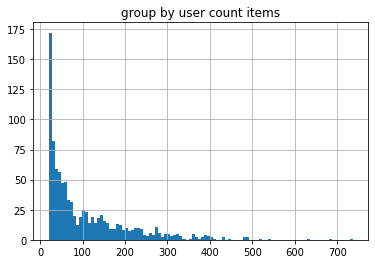

In [32]:
import matplotlib.pyplot as plt
# plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
# plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
movies_by_user = data.groupby('userid')
res = movies_by_user['movieid'].count().hist(bins=100)
res.set_title("group by user count items")

回到我们的问题，我们是要针对影片进行推荐，同时借助以往的观影记录来评价影片是否受欢迎，这里我们使用已有的评分(rating)特征来进行分类

下面我们对rating数据分布进行观察,通过直方图分析一下评分数据的分布

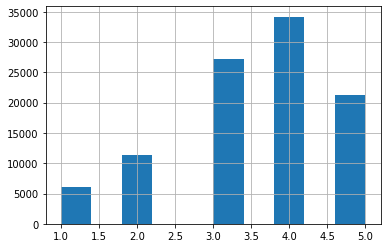

In [33]:
data['rating'].hist()

由上图可以看出评分的分布情况，这里我们已4分为分界线，大于等于4分的影片认为是喜欢，小于是不喜欢。

这个值可以根据自己的需求确定，如果希望模型更保守一些的话可以设置的更大一些

### 数据预处理

In [38]:
nbUsers=943 # 根据上面的统计可知用户数量为943
nbMovies=1682 # 根据上面的统计可知影片数量为1682
nbFeatures=nbUsers+nbMovies # 将用户总数和影片数量进行求和，获得因子分解机 的特征维度总数

nbRatingsTrain=90570 # 评分数据也就是用户交互数据，训练集大小，交互数据总量是10000
nbRatingsTest=9430 # 评分数据也就是用户交互数据，测试集大小

In [42]:
# 对于每个用户，生成影片的评分列表.
# 我们需要这个来添加随机的负样本。
moviesByUser = {}
for userId in range(nbUsers):
    moviesByUser[str(userId)]=[]
 
with open('ml-100k/ua.base','r') as f:
    samples=csv.reader(f,delimiter='\t')
    for userId,movieId,rating,timestamp in samples:
        moviesByUser[str(int(userId)-1)].append(int(movieId)-1) ## 生成随机负样本


![one-hot encoding](images/one-hot.png)

使用独热编码对数据进行处理，已便于模型进行处理,使用one-hot编码，将离散特征的取值扩展到了欧式空间，离散特征的某个取值就对应欧式空间的某个点

将离散特征 扩展到欧式空间，从而更便于并合理的进行 特征之间距离的计算.

因子分解机的训练是针对稀疏矩阵的，因此我们要将数据集中电影、评分、用户的序列转为稀疏矩阵，并根据用户评分的结果生成标签向量

In [44]:
def loadDataset(filename, lines, columns):
    # 使用lil_matrix 数据结构存储
    X = lil_matrix((lines, columns)).astype('float32')
    #  将标签数据存储到向量中
    Y = []
    line=0
    with open(filename,'r') as f:
        samples=csv.reader(f,delimiter='\t')
        for userId,movieId,rating,timestamp in samples:
            X[line,int(userId)-1] = 1
            X[line,int(nbUsers)+int(movieId)-1] = 1
            if int(rating) >= 4:
                Y.append(1)
            else:
                Y.append(0)
            line=line+1
            
    Y=np.array(Y).astype('float32')
    return X,Y

In [46]:
X_train, Y_train = loadDataset('ml-100k/ua.base', nbRatingsTrain, nbFeatures)
X_test, Y_test = loadDataset('ml-100k/ua.test',nbRatingsTest,nbFeatures)

现在我们的训练数据集和测试数据集已经准备完毕，下来对数据集的样本数量进行验证
同时分析一下标签数据的分布

In [49]:
print('训练数据集：特征部分向量形状：',X_train.shape)
print('训练数据集：标签部分向量形状：',Y_train.shape)
assert X_train.shape == (nbRatingsTrain, nbFeatures) ##校验训练集与设定的训练集大小是否一致，同时验证特征维度是否一致
assert Y_train.shape == (nbRatingsTrain, )##校验训练集标签数量 是否与训练集大小一致
zero_labels = np.count_nonzero(Y_train) ## 统计标签为0的数量
print("训练集中标签为0的有: %d 个,标签为1的有 %d 个" % (zero_labels, nbRatingsTrain-zero_labels))

print('测试数据集：特征部分向量形状：',X_test.shape)
print('测试数据集：标签部分向量形状：',Y_test.shape)
assert X_test.shape  == (nbRatingsTest, nbFeatures) #校验测试集
assert Y_test.shape  == (nbRatingsTest, ) #校验测试集
zero_labels = np.count_nonzero(Y_test)
print("测试集中标签为0的有: %d 个,标签为1的有 %d 个"  % (zero_labels, nbRatingsTest-zero_labels))

训练数据集：特征部分向量形状： (90570, 2625)
训练数据集：标签部分向量形状： (90570,)
训练集中标签为0的有: 49906 个,标签为1的有 40664 个
测试数据集：特征部分向量形状： (9430, 2625)
测试数据集：标签部分向量形状： (9430,)
测试集中标签为0的有: 5469 个,标签为1的有 3961 个


从数据分布看，我们的训练数据和测试数据的正负样本还是比较均衡的，这样有利于我们的模型训练，减少了模型出现过拟合的概率

### 将csv转换为protobuf 存储到 S3

稀疏矩阵中绝大多数元素均为0，如果直接保存稀疏矩阵，会占用大量的存储空间，因此我们将其转为protobuf格式的数据，并保存到S3。

In [50]:
bucket = 'sagemaker-us-west-2-517141035927'
prefix = 'sagemaker/fm-movielens'

train_key      = 'train.protobuf'
train_prefix   = '{}/{}'.format(prefix, 'train3')

test_key       = 'test.protobuf'
test_prefix    = '{}/{}'.format(prefix, 'test3')

output_prefix  = 's3://{}/{}/output'.format(bucket, prefix)

In [15]:
def writeDatasetToProtobuf(X, Y, bucket, prefix, key):
    buf = io.BytesIO()
    smac.write_spmatrix_to_sparse_tensor(buf, X, Y)
    buf.seek(0)
    obj = '{}/{}'.format(prefix, key)
    boto3.resource('s3').Bucket(bucket).Object(obj).upload_fileobj(buf)
    return 's3://{}/{}'.format(bucket,obj)
    
train_data = writeDatasetToProtobuf(X_train, Y_train, bucket, train_prefix, train_key)    
test_data  = writeDatasetToProtobuf(X_test, Y_test, bucket, test_prefix, test_key)    
  
print(train_data)
print(test_data)
print('Output: {}'.format(output_prefix))

s3://sagemaker-us-west-2-517141035927/sagemaker/fm-movielens/train3/train.protobuf
s3://sagemaker-us-west-2-517141035927/sagemaker/fm-movielens/test3/test.protobuf
Output: s3://sagemaker-us-west-2-517141035927/sagemaker/fm-movielens/output


### 模型训练

FM是Amazon SageMaker自带的算法之一，因此通过Amazon SageMaker训练模型非常容易。
* 首先我们需要引入SageMaker的SDK，并建立Amazon SageMaker的session、定义位于该Region的因子分解机算法Container以及获取SageMaker的运行角色。
* 随后我们定义FM训练需要的一些参数。首先是环境参数，包括之前定义好的Container、角色、输出位置和session、还包括训练使用的EC2实例，本例中采用“ml.c4.xlarge”来训练。
* 之后，我们需要定义FM算法的超参（Hyperparameters）。在本例中特征列为用户数与电影数的总和、预测方式为二分类（即结果为判断“喜爱”或是“不喜爱”）、最小批量为1000、epoch时期为50次。其中num_factors即为在算法介绍中提到的潜藏特征K的数量，根据Amazon SageMaker官方文档的说明，建议在2-1000之间，通常64为最优值，因此，我们也设为64。
* 最后为模型提供训练集和测试集在S3中的位置，训练就开始了。

In [16]:
containers = {'us-west-2': '174872318107.dkr.ecr.us-west-2.amazonaws.com/factorization-machines:latest',
              'us-east-1': '382416733822.dkr.ecr.us-east-1.amazonaws.com/factorization-machines:latest',
              'us-east-2': '404615174143.dkr.ecr.us-east-2.amazonaws.com/factorization-machines:latest',
              'eu-west-1': '438346466558.dkr.ecr.eu-west-1.amazonaws.com/factorization-machines:latest'}

In [17]:
fm = sagemaker.estimator.Estimator(containers[boto3.Session().region_name],
                                   get_execution_role(), 
                                   train_instance_count=1, 
                                   train_instance_type='ml.c4.xlarge',
                                   output_path=output_prefix,
                                   sagemaker_session=sagemaker.Session())

fm.set_hyperparameters(feature_dim=nbFeatures,
                      predictor_type='binary_classifier',
                      mini_batch_size=1000,
                      num_factors=64,
                      epochs=100)

fm.fit({'train': train_data, 'test': test_data})

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


2020-12-07 10:28:28 Starting - Starting the training job...
2020-12-07 10:28:30 Starting - Launching requested ML instances......
2020-12-07 10:29:40 Starting - Preparing the instances for training...
2020-12-07 10:30:25 Downloading - Downloading input data......
2020-12-07 10:31:24 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python2.7/site-packages/pandas/util/nosetester.py:13: DeprecationWarning: Importing from numpy.testing.nosetester is deprecated, import from numpy.testing instead.
  from numpy.testing import nosetester
[12/07/2020 10:31:26 INFO 140711371384640] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'factors_lr': u'0.0001', u'linear_init_sigma': u'0.01', u'epochs': 1, u'_wd': u'1.0', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'factors_init_sigma': u'0.001', u'

从日志可以看到F1值达到0.738987986895，F1分数（F1-score）是分类问题的一个衡量指标。 它是精确率和召回率的调和平均数，最大为1，最小为0。

### 模型部署
最后就是模型部署，Endpoint可以理解为模型基于http访问的API接口，有了Endpoint就可以进行预测服务了。

In [22]:
fm_predictor = fm.deploy(instance_type='ml.c4.xlarge', initial_instance_count=1)

-------------!

In [33]:
fm_predictor.endpoint_name

'factorization-machines-2020-12-08-02-41-09-967'

In [49]:
def fm_serializer(data):
    js = {'instances': []}
    for row in data:
        js['instances'].append({'features': row.tolist()})
    print(js)
    return json.dumps(js)

fm_predictor.content_types = 'application/json'
fm_predictor.serializer =  sagemaker.serializers.JSONSerializer()
fm_predictor.deserializer = sagemaker.deserializers.JSONDeserializer()

### 模型推理

最后我们进行一个简单的预测，从参与训练的电影库中推荐10部电影给某个已存在的用户。
首先生成该用于的稀疏矩阵。


数据集中的用户ID和电影ID均为随机字符串，为了模型训练后预测结果的数据对应，我们首先为用户和电影分别建立由0开始的index序列，并使其与ID字符串对应。

In [96]:
# 生成该用户的稀疏矩阵
def createInferenceForUser(userId, lines, columns):
    X = lil_matrix((lines, columns)).astype('float32')
    line = 0
    for line in range(0, lines):
        X[line,int(userId)-1] = 1
        X[line,int(nbUsers)+int(movieId)-1] = 1
        line=line+1

    print(X.shape)
    return X

# 随机选择一个用户ID为456
user_inference = createInferenceForUser('456', nbMovies, nbUsers + nbMovies)
print(user_inference.shape)
print(user_inference[1000:1001])

(1682, 2625)
(1682, 2625)
  (0, 455)	1.0
  (0, 2272)	1.0


* 使用sagemaker SDK 的Predictor 推理

In [92]:
result = fm_predictor.predict(X_test[1000:1010].toarray())
print(result)
print (Y_test[1000:1010])

* boto3 SDK 通过 sagemaker endpoint来推理，此方法常用语应用集成

In [98]:
import boto3
import json
from sagemaker.predictor import json_deserializer

#invoke endpoint
client = boto3.client('sagemaker-runtime')

def fm_serializer(data):
    js = {'instances': []}
    for row in data:
        js['instances'].append({'features': row.tolist()})
    return json.dumps(js)


raw_response = client.invoke_endpoint(
                EndpointName = 'factorization-machines-2020-12-08-02-41-09-967',
                Body = fm_serializer(user_inference[1000:1001].toarray()),
                ContentType='application/json')
# print(raw_response)

result = json.loads(raw_response['Body'].read())

print(result)


{'predictions': [{'score': 0.26429685950279236, 'predicted_label': 0.0}]}
